0.7078382878295588
Confusion Matrix
[[8.87417219e-01 9.80132450e-02 1.42857143e-02 2.83822138e-04
  0.00000000e+00]
 [3.37800894e-01 4.68827099e-01 1.83703407e-01 8.80176035e-03
  8.66840035e-04]
 [5.00409333e-02 2.50818666e-01 6.05403193e-01 7.74662300e-02
  1.62709783e-02]
 [5.90349076e-03 2.87474333e-02 3.91683778e-01 4.38911704e-01
  1.34753593e-01]
 [7.39247312e-03 4.03225806e-03 7.93010753e-02 2.42607527e-01
  6.66666667e-01]]


['Prediction.joblib']

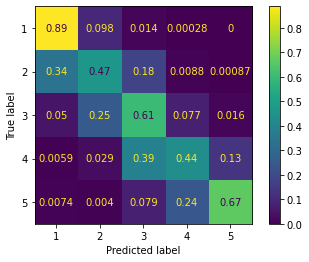

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from joblib import dump, load


#parses all lines in the file, stores data
def extractData(file1, total, target):
    for line in file1:
        currentIndex = 0
        lineStorage = []

        # separates data within line
        while len(line) > 1:
            index = line.find('\t')
            if index == -1:
                index = len(line)
            data = line[0:index]
            line = line[index+1:len(line)]

            #length, views, rate, ratings, and number of comments of each video stored for later
            if 5 <= currentIndex <= 8:
                if currentIndex == 5:
                    target += [float(data)]  # total views
                #elif currentIndex == 6:
                    #x=0
                else:
                    lineStorage += [float(data)]

            currentIndex += 1

        if currentIndex >= 4:
            lineStorage += [(lineStorage[0] - 3.0) * lineStorage[1]]  # comment quality * num comments
            lineStorage += [(lineStorage[1] + 0.01) / (lineStorage[2] + 0.01)]  # num ratings / num comments
            lineStorage += [lineStorage[2] - lineStorage[1]]  # comments - ratings

            total += [lineStorage]

totalData = []
targetData = []

cwd = os.getcwd()
# extracts data from files
extractData(open(cwd + "/0.txt", "r"), totalData, targetData)
extractData(open(cwd + "/1.txt", "r"), totalData, targetData)
extractData(open(cwd + "/2.txt", "r"), totalData, targetData)
extractData(open(cwd + "/3.txt", "r"), totalData, targetData)

viewSave = []


#separates data into training and test sections
trainData, testData, trainTarget, testTarget = train_test_split(totalData, targetData, test_size=0.2, random_state=None)

x = 0
for data in trainTarget:
    #if data < 1000.0:
        #data = 1
    if data< 10000.0:
        data = 1
    elif data < 50000.0:
        data = 2
    elif data < 250000.0:
        data = 3
    elif data < 1000000.0:
        data = 4
    else:
        data = 5

    trainTarget[x] = data
    x += 1
    
x = 0
for data in testTarget:
    viewSave += [data]
    #if data < 1000.0:
        #data = 1
    if data< 10000.0:
        data = 1
    elif data < 50000.0:
        data = 2
    elif data < 250000.0:
        data = 3
    elif data < 1000000.0:
        data = 4
    else:
        data = 5

    testTarget[x] = data
    x += 1

viewPredict = AdaBoostClassifier(n_estimators = 400, learning_rate = .7)


viewPredict.fit(trainData, trainTarget)
prediction = viewPredict.predict(testData)

sampleTest = []

print(viewPredict.score(testData, testTarget))
disp = plot_confusion_matrix(viewPredict, testData, testTarget,normalize='true')

print("Confusion Matrix")
print(disp.confusion_matrix)

dump(viewPredict, 'Prediction.joblib')




(0.0, 3000.0)

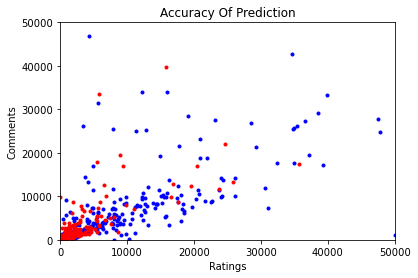

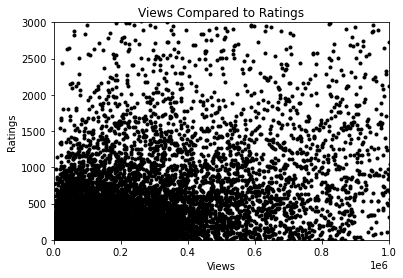

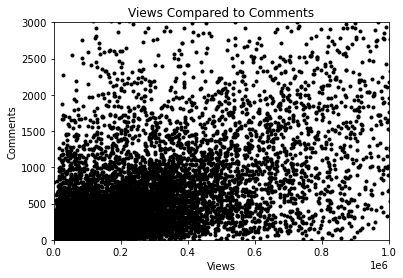

In [50]:
correctX = []
correctY = []
incorrectX = []
incorrectY = []

# variables for graphs
correctX = []
correctY = []
incorrectX = []
incorrectY = []

commentArr = []
ratingArr = []

x = 0
for video in testTarget:
    # reduces bunching of data points
    videoCutoff = int(50000 / (testData[x][1] + testData[x][2] + 200) + 1)
    commentArr += [testData[x][1]]
    ratingArr += [testData[x][2]]
    
    if x % videoCutoff == 0:
        if video == prediction[x]:
            correctX += [testData[x][1]]
            correctY += [testData[x][2]]
        else:
            incorrectX += [testData[x][1]]
            incorrectY += [testData[x][2]]
    x += 1

# outputs graph with labels
plt.figure(1)
plt.xlabel('Ratings')
plt.ylabel('Comments')
plt.title('Accuracy Of Prediction')
plt.plot(correctX, correctY, linestyle='none', marker='.', color='blue')
plt.plot(incorrectX, incorrectY, linestyle='none', marker='.', color='red')
axes = plt.gca()
axes.set_xlim([0,50000])
axes.set_ylim([0,50000])

plt.figure(2)
plt.xlabel('Views')
plt.ylabel('Ratings')
plt.title('Views Compared to Ratings')
plt.plot(viewSave, ratingArr, linestyle='none', marker='.', color='black')
axes = plt.gca()
axes.set_xlim([0,1000000])
axes.set_ylim([0,3000])

plt.figure(3)
plt.xlabel('Views')
plt.ylabel('Comments')
plt.title('Views Compared to Comments')
plt.plot(viewSave, commentArr, linestyle='none', marker='.', color='black')
axes = plt.gca()
axes.set_xlim([0,1000000])
axes.set_ylim([0,3000])

In [2]:
import PySimpleGUI as sg
from joblib import dump, load
import numpy as np
import pandas as pd

clf = load('Prediction.joblib')
sg.theme('Dark Blue 3')  # please make your windows colorful

layout = [[sg.Text('Enter Number of Ratings: \t'), sg.Input(key = '-RatingCount-', size = (20,1))],
          [sg.Text('Enter Average Rating: \t'), sg.Input(key = '-AvgRating-', size = (20,1))],
          [sg.Text('Number of Comments: \t'), sg.Input(key = '-CommentCount-', size = (20,1))],
          [sg.Text(key = '-OUT-', size = (50,2))],
          [sg.Text('')],
          [sg.Button('Predict'), sg.Button('Exit')]]

window = sg.Window('Predict Views', layout)

while True:  # Event Loop
    event, values = window.read()
    print(event, values)
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    if event == 'Predict':
        # change the "output" element to be the value of "input" element
        print(int(values['-RatingCount-']))
        X = (float(values['-AvgRating-']), int(values['-RatingCount-']), int(values['-CommentCount-']),
             (float(values['-AvgRating-'])-3.0) * int(values['-RatingCount-']),
             (int(values['-RatingCount-'])+.01)/(int(values['-CommentCount-'])+.01), 
            int(values['-RatingCount-'])-int(values['-CommentCount-']))
        X= np.reshape(X, (1,-1))
        print(X)
        Predict_X = clf.predict(X)
        if Predict_X[0] == 1:
            window['-OUT-'].update('Based on the given data, this program predicts that the video has less than 10,000 Views.')
        elif Predict_X[0] == 2:
            window['-OUT-'].update('Based on the given data, this program predicts that the video has between 10,000 and 50,000 Views.')
        elif Predict_X[0] == 3:
            window['-OUT-'].update('Based on the given data, this program predicts that the video has between 50,000 and 250,000 Views.')
        elif Predict_X[0] == 4:
            window['-OUT-'].update('Based on the given data, this program predicts that the video has between 250,000 and 1,000,000 Views.')
        elif Predict_X[0] == 5:
            window['-OUT-'].update('Based on the given data, this program predicts that the video has greater than 1,000,000 Views.')
        
        print(values)

window.close()


Predict {'-RatingCount-': '500', '-AvgRating-': '4.8', '-CommentCount-': '37'}
500
[[  4.8       500.         37.        900.         13.5101324 463.       ]]
{'-RatingCount-': '500', '-AvgRating-': '4.8', '-CommentCount-': '37'}
Exit {'-RatingCount-': '500', '-AvgRating-': '4.8', '-CommentCount-': '37'}
